In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
from sklearn.metrics import mean_squared_error
from tqdm import tqdm_notebook
import numpy as np
import matplotlib.pyplot as plt

from yaringal_dataset import loader
from weight_drop import WeightDrop
from embed_regularize import embedded_dropout
from locked_dropout import LockedDropout

%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams["figure.figsize"] = (10, 5)

# Global params:
NB_WORDS = 20000
SKIP_TOP = 0
TEST_SPLIT = 0.2
INIT_SEED = 2017
GLOBAL_SEED = 2018
MAXLEN = 200
BATCH_SIZE = 128
TEST_BATCH_SIZE = 512

In [2]:
dataset = loader(INIT_SEED, MAXLEN, NB_WORDS, SKIP_TOP, TEST_SPLIT)

X_train, X_test, Y_train, Y_test = dataset.X_train, dataset.X_test, dataset.Y_train, dataset.Y_test
mean_y_train, std_y_train = dataset.mean_y_train, dataset.std_y_train

10620 train sequences
2655 test sequences
Pad sequences (samples x time)
X_train shape: (10620, 200)
X_test shape: (2655, 200)


In [3]:
def inverse_transform(v):
    return v * std_y_train + mean_y_train 

In [4]:
class Model(nn.Module):
    def __init__(self, nb_words, hidden_size=128, embedding_size=128, n_layers=1,
                 wdrop=0.25, odrop=0.25, edrop=0.1, idrop=0.25, variational=False,
                 standard_dropout=False, batch_first=True):
        super(Model, self).__init__()
        self.standard_dropout = standard_dropout
        self.lockdrop = LockedDropout(batch_first=batch_first)
        self.odrop = odrop
        self.idrop = idrop
        self.edrop = edrop
        self.n_layers = n_layers
        self.embedding = nn.Embedding(nb_words, embedding_size)
        self.rnns = [
            nn.LSTM(embedding_size if l == 0 else hidden_size,
                   hidden_size, num_layers=1, batch_first=batch_first)
            for l in range(n_layers)
        ]
        if wdrop:
            self.rnns = [WeightDrop(rnn, ['weight_hh_l0'], dropout=wdrop, variational=variational)
                         for rnn in self.rnns]
        self.rnns = torch.nn.ModuleList(self.rnns)
        self.output_layer = nn.Linear(hidden_size, 1)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.output_layer.bias.data.fill_(0)
        self.output_layer.weight.data.uniform_(-initrange, initrange)
        
    def forward(self, X):
        emb = embedded_dropout(self.embedding, X, dropout=self.edrop if self.training else 0)
        if self.standard_dropout:
            raw_output = F.dropout(emb, p=self.idrop, training=self.training)
        else:
            raw_output = self.lockdrop(emb, self.idrop)
        new_hidden, new_cell_state = [], []
        for l, rnn in enumerate(self.rnns):
            raw_output, (new_h, new_c) = rnn(raw_output)
            if self.standard_dropout:
                raw_output = F.dropout(raw_output, p=self.odrop, training=self.training)
            else:
                raw_output = self.lockdrop(raw_output, self.odrop)         
            new_hidden.append(new_h)
            new_cell_state.append(new_c)
        hidden = torch.cat(new_hidden, 0)
        cell_state = torch.cat(new_cell_state, 0)
        final_output = self.output_layer(raw_output)
        return final_output[:, -1, 0], hidden, cell_state

In [5]:
MC_ROUNDS = 10
def fit(model, optimizer, X_train_tensor, Y_train_tensor, 
        X_test_tensor, Y_test_tensor, n_epochs=30, mc_dropout=True):
    epoch_losses = []
    criterion = torch.nn.MSELoss()
    for epoch in range(n_epochs):
        indices = torch.randperm(len(X_train)).cuda()
        losses, losses_raw = [], []
        model.train()
        for i in range(0, len(X_train), BATCH_SIZE): #tqdm_notebook(range(0, len(X_train), BATCH_SIZE)):
            optimizer.zero_grad()
            pred, _, _ = model(Variable(X_train_tensor[indices[i:(i+BATCH_SIZE)]]))
            loss_raw = criterion(
                pred,
                Variable(Y_train_tensor[indices[i:(i+BATCH_SIZE)]], requires_grad=False)
            )
            loss = F.mse_loss(inverse_transform(pred),
                              inverse_transform(
                                  Variable(Y_train_tensor[indices[i:(i+BATCH_SIZE)]], requires_grad=False)))
            losses_raw.append(loss_raw.data.cpu()[0])
            losses.append(loss.data.cpu()[0])
            loss_raw.backward()
            optimizer.step()
        train_loss = np.mean(losses)** 0.5
        train_loss_raw = np.mean(losses_raw)
        # Standard dropout approximation
        losses, losses_raw = [], []
        model.eval()    
        for i in range(0, len(X_test), TEST_BATCH_SIZE):
            pred_test, _, _ = model(Variable(X_test_tensor[i:(i+TEST_BATCH_SIZE)], volatile=True))
            loss_raw = F.mse_loss(pred_test, Variable(Y_test_tensor[i:(i+TEST_BATCH_SIZE)]))
            loss = F.mse_loss(inverse_transform(pred_test),
                              inverse_transform(Variable(Y_test_tensor[i:(i+TEST_BATCH_SIZE)])))
            losses_raw.append(loss_raw.data.cpu()[0])
            losses.append(loss.data.cpu()[0])
        std_test_loss = np.mean(losses) ** 0.5
        std_test_loss_raw = np.mean(losses_raw)
        if mc_dropout:
            # MC dropout
            losses, losses_raw = [], []
            model.train()
            for i in range(0, len(X_test), TEST_BATCH_SIZE):
                pred_list = []
                for j in range(MC_ROUNDS):
                    pred_test, _, _ = model(Variable(X_test_tensor[i:(i+TEST_BATCH_SIZE)], volatile=True))
                    pred_list.append(pred_test.unsqueeze(0))
                pred_all = torch.mean(torch.cat(pred_list, 0), 0)
                loss_raw = F.mse_loss(pred_all, Variable(Y_test_tensor[i:(i+TEST_BATCH_SIZE)]))
                loss = F.mse_loss(inverse_transform(pred_all),
                                  inverse_transform(Variable(Y_test_tensor[i:(i+TEST_BATCH_SIZE)])))        
                losses_raw.append(loss_raw.data.cpu()[0])
                losses.append(loss.data.cpu()[0])    
            mc_test_loss = np.mean(losses) ** 0.5
            mc_test_loss_raw = np.mean(losses_raw)
            epoch_losses.append([
                train_loss, std_test_loss, mc_test_loss,
                train_loss_raw, std_test_loss_raw, mc_test_loss_raw
            ])
            print("Epoch: {} Train: {:.4f}/{:.4f}, Val Std: {:.4f}/{:.4f}, Val MC: {:.4f}/{:.4f}".format(
                epoch, train_loss, std_test_loss_raw, std_test_loss, std_test_loss_raw, mc_test_loss, mc_test_loss_raw))
        else:
            epoch_losses.append([train_loss, std_test_loss, mc_test_loss])
            print("Epoch: {} Train: {:.4f}/{:.4f}, Val Std: {:.4f}/{:.4f}".format(
                epoch, train_loss, std_test_loss_raw, std_test_loss, std_test_loss_raw))
    return epoch_losses

In [6]:
Y_train_tensor =  torch.from_numpy(Y_train).float().cuda()
Y_test_tensor =  torch.from_numpy(Y_test).float().cuda()
X_train_tensor =  torch.from_numpy(X_train).long().cuda()
X_test_tensor =  torch.from_numpy(X_test).long().cuda()

## Weight Dropped LSTM (w Embedding Dropout)

In [22]:
model_1 = Model(NB_WORDS + dataset.index_from, wdrop=0.05, odrop=0.1, edrop=0.2, idrop=0.1)
model_1.cuda()
optimizer = torch.optim.Adam([
            {'params': model_1.parameters(), 'lr': 1e-4, 'weight_decay': 2e-5}
        ],)
epoch_losses_1 = fit(
    model_1, optimizer, X_train_tensor, Y_train_tensor, X_test_tensor, Y_test_tensor, n_epochs=50)

Applying weight drop of 0.05 to weight_hh_l0


/opt/conda/lib/python3.6/site-packages/torch/nn/modules/module.py:224: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greately increasing memory usage. To compact weights again call flatten_parameters().
  result = self.forward(*input, **kwargs)


Epoch: 0 Train: 0.1853/0.9990, Val Std: 0.1852/0.9990, Val MC: 0.1852/0.9990
Epoch: 1 Train: 0.1851/0.9984, Val Std: 0.1851/0.9984, Val MC: 0.1851/0.9985
Epoch: 2 Train: 0.1850/0.9977, Val Std: 0.1851/0.9977, Val MC: 0.1851/0.9978
Epoch: 3 Train: 0.1848/0.9969, Val Std: 0.1850/0.9969, Val MC: 0.1850/0.9971
Epoch: 4 Train: 0.1845/0.9950, Val Std: 0.1848/0.9950, Val MC: 0.1848/0.9950
Epoch: 5 Train: 0.1836/0.9772, Val Std: 0.1832/0.9772, Val MC: 0.1832/0.9775
Epoch: 6 Train: 0.1775/0.8894, Val Std: 0.1747/0.8894, Val MC: 0.1756/0.8983
Epoch: 7 Train: 0.1664/0.7414, Val Std: 0.1595/0.7414, Val MC: 0.1614/0.7583
Epoch: 8 Train: 0.1559/0.6806, Val Std: 0.1529/0.6806, Val MC: 0.1542/0.6930
Epoch: 9 Train: 0.1484/0.6351, Val Std: 0.1477/0.6351, Val MC: 0.1496/0.6521
Epoch: 10 Train: 0.1369/0.6084, Val Std: 0.1445/0.6084, Val MC: 0.1458/0.6188
Epoch: 11 Train: 0.1335/0.6317, Val Std: 0.1473/0.6317, Val MC: 0.1497/0.6527
Epoch: 12 Train: 0.1270/0.5926, Val Std: 0.1426/0.5926, Val MC: 0.1454/0.6

## No Dropout

In [8]:
model_2 = Model(NB_WORDS + dataset.index_from, wdrop=0, odrop=0, edrop=0, idrop=0)
model_2.cuda()
optimizer = torch.optim.Adam([
            {'params': model_2.parameters(), 'lr': 1e-4}
        ],)
epoch_losses_2 = fit(
    model_2, optimizer, X_train_tensor, Y_train_tensor, X_test_tensor, Y_test_tensor, n_epochs=50)

Epoch: 0 Train: 0.1853/0.9989, Val Std: 0.1852/0.9989, Val MC: 0.1852/0.9989
Epoch: 1 Train: 0.1851/0.9979, Val Std: 0.1851/0.9979, Val MC: 0.1851/0.9979
Epoch: 2 Train: 0.1849/0.9967, Val Std: 0.1850/0.9967, Val MC: 0.1850/0.9967
Epoch: 3 Train: 0.1845/0.9941, Val Std: 0.1847/0.9941, Val MC: 0.1847/0.9941
Epoch: 4 Train: 0.1824/0.9390, Val Std: 0.1795/0.9390, Val MC: 0.1795/0.9390
Epoch: 5 Train: 0.1628/0.6927, Val Std: 0.1542/0.6927, Val MC: 0.1542/0.6927
Epoch: 6 Train: 0.1369/0.6395, Val Std: 0.1482/0.6395, Val MC: 0.1482/0.6395
Epoch: 7 Train: 0.1211/0.6015, Val Std: 0.1437/0.6015, Val MC: 0.1437/0.6015
Epoch: 8 Train: 0.1098/0.5860, Val Std: 0.1418/0.5860, Val MC: 0.1418/0.5860
Epoch: 9 Train: 0.1020/0.6120, Val Std: 0.1450/0.6120, Val MC: 0.1450/0.6120
Epoch: 10 Train: 0.0957/0.6005, Val Std: 0.1436/0.6005, Val MC: 0.1436/0.6005
Epoch: 11 Train: 0.0904/0.5949, Val Std: 0.1429/0.5949, Val MC: 0.1429/0.5949
Epoch: 12 Train: 0.0863/0.6030, Val Std: 0.1439/0.6030, Val MC: 0.1439/0.6

## Naive Dropout (w/o Embedding Dropout)

In [9]:
model_3 = Model(NB_WORDS + dataset.index_from, 
                wdrop=0, odrop=0.2, edrop=0, idrop=0.2, standard_dropout=True)
model_3.cuda()
optimizer = torch.optim.Adam([
            {'params': model_3.parameters(), 'lr': 1e-4, 'weight_decay': 2e-5}
        ],)
epoch_losses_3 = fit(
    model_3, optimizer, X_train_tensor, Y_train_tensor, X_test_tensor, Y_test_tensor, n_epochs=50)

Epoch: 0 Train: 0.1854/0.9995, Val Std: 0.1852/0.9995, Val MC: 0.1852/0.9995
Epoch: 1 Train: 0.1852/0.9988, Val Std: 0.1852/0.9988, Val MC: 0.1852/0.9990
Epoch: 2 Train: 0.1851/0.9979, Val Std: 0.1851/0.9979, Val MC: 0.1851/0.9979
Epoch: 3 Train: 0.1849/0.9969, Val Std: 0.1850/0.9969, Val MC: 0.1850/0.9970
Epoch: 4 Train: 0.1846/0.9949, Val Std: 0.1848/0.9949, Val MC: 0.1848/0.9946
Epoch: 5 Train: 0.1831/0.9782, Val Std: 0.1833/0.9782, Val MC: 0.1833/0.9786
Epoch: 6 Train: 0.1712/0.7441, Val Std: 0.1598/0.7441, Val MC: 0.1600/0.7459
Epoch: 7 Train: 0.1473/0.6467, Val Std: 0.1490/0.6467, Val MC: 0.1492/0.6481
Epoch: 8 Train: 0.1299/0.6085, Val Std: 0.1445/0.6085, Val MC: 0.1450/0.6122
Epoch: 9 Train: 0.1184/0.5899, Val Std: 0.1423/0.5899, Val MC: 0.1418/0.5858
Epoch: 10 Train: 0.1115/0.5715, Val Std: 0.1401/0.5715, Val MC: 0.1404/0.5744
Epoch: 11 Train: 0.1053/0.5675, Val Std: 0.1396/0.5675, Val MC: 0.1401/0.5716
Epoch: 12 Train: 0.1010/0.5706, Val Std: 0.1400/0.5706, Val MC: 0.1401/0.5

## Variational LSTM

In [25]:
model_4 = Model(NB_WORDS + dataset.index_from, wdrop=0.02, odrop=0.1, edrop=0.1, idrop=0.1, variational=True)
model_4.cuda()
optimizer = torch.optim.Adam([
            {'params': model_4.parameters(), 'lr': 1e-4, 'weight_decay': 2e-5}
        ],)
epoch_losses_4 = fit(
    model_4, optimizer, X_train_tensor, Y_train_tensor, X_test_tensor, Y_test_tensor, n_epochs=50)

Applying weight drop of 0.02 to weight_hh_l0


/opt/conda/lib/python3.6/site-packages/torch/nn/modules/module.py:224: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greately increasing memory usage. To compact weights again call flatten_parameters().
  result = self.forward(*input, **kwargs)


Epoch: 0 Train: 0.1853/0.9990, Val Std: 0.1852/0.9990, Val MC: 0.1852/0.9993
Epoch: 1 Train: 0.1851/0.9983, Val Std: 0.1851/0.9983, Val MC: 0.1851/0.9984
Epoch: 2 Train: 0.1850/0.9973, Val Std: 0.1850/0.9973, Val MC: 0.1850/0.9971
Epoch: 3 Train: 0.1847/0.9951, Val Std: 0.1848/0.9951, Val MC: 0.1848/0.9953
Epoch: 4 Train: 0.1836/0.9770, Val Std: 0.1831/0.9770, Val MC: 0.1830/0.9753
Epoch: 5 Train: 0.1832/0.9738, Val Std: 0.1828/0.9738, Val MC: 0.1827/0.9727
Epoch: 6 Train: 0.1773/0.9053, Val Std: 0.1763/0.9053, Val MC: 0.1765/0.9073
Epoch: 7 Train: 0.1645/0.7888, Val Std: 0.1646/0.7888, Val MC: 0.1645/0.7878
Epoch: 8 Train: 0.1542/0.7397, Val Std: 0.1594/0.7397, Val MC: 0.1609/0.7540
Epoch: 9 Train: 0.1447/0.7257, Val Std: 0.1578/0.7257, Val MC: 0.1527/0.6793
Epoch: 10 Train: 0.1374/0.7051, Val Std: 0.1556/0.7051, Val MC: 0.1504/0.6585
Epoch: 11 Train: 0.1311/0.6364, Val Std: 0.1478/0.6364, Val MC: 0.1462/0.6230
Epoch: 12 Train: 0.1267/0.6328, Val Std: 0.1474/0.6328, Val MC: 0.1466/0.6

## Variational LSTM w/o Recurrent Dropout

In [26]:
model_5 = Model(NB_WORDS + dataset.index_from, wdrop=0, odrop=0.1, edrop=0.2, idrop=0.1)
model_5.cuda()
optimizer = torch.optim.Adam([
            {'params': model_5.parameters(), 'lr': 1e-4, 'weight_decay': 2e-5}
        ],)
epoch_losses_5 = fit(
    model_5, optimizer, X_train_tensor, Y_train_tensor, X_test_tensor, Y_test_tensor, n_epochs=50)

Epoch: 0 Train: 0.1853/0.9990, Val Std: 0.1852/0.9990, Val MC: 0.1852/0.9991
Epoch: 1 Train: 0.1852/0.9984, Val Std: 0.1851/0.9984, Val MC: 0.1852/0.9986
Epoch: 2 Train: 0.1851/0.9978, Val Std: 0.1851/0.9978, Val MC: 0.1851/0.9979
Epoch: 3 Train: 0.1849/0.9968, Val Std: 0.1850/0.9968, Val MC: 0.1850/0.9968
Epoch: 4 Train: 0.1846/0.9950, Val Std: 0.1848/0.9950, Val MC: 0.1848/0.9949
Epoch: 5 Train: 0.1837/0.9781, Val Std: 0.1832/0.9781, Val MC: 0.1832/0.9780
Epoch: 6 Train: 0.1825/0.9727, Val Std: 0.1827/0.9727, Val MC: 0.1828/0.9734
Epoch: 7 Train: 0.1774/0.8957, Val Std: 0.1754/0.8957, Val MC: 0.1754/0.8957
Epoch: 8 Train: 0.1643/0.7831, Val Std: 0.1640/0.7831, Val MC: 0.1644/0.7875
Epoch: 9 Train: 0.1497/0.7111, Val Std: 0.1562/0.7111, Val MC: 0.1565/0.7134
Epoch: 10 Train: 0.1375/0.6047, Val Std: 0.1441/0.6047, Val MC: 0.1456/0.6172
Epoch: 11 Train: 0.1290/0.5989, Val Std: 0.1434/0.5989, Val MC: 0.1452/0.6145
Epoch: 12 Train: 0.1231/0.6097, Val Std: 0.1447/0.6097, Val MC: 0.1457/0.6

## Visualizations

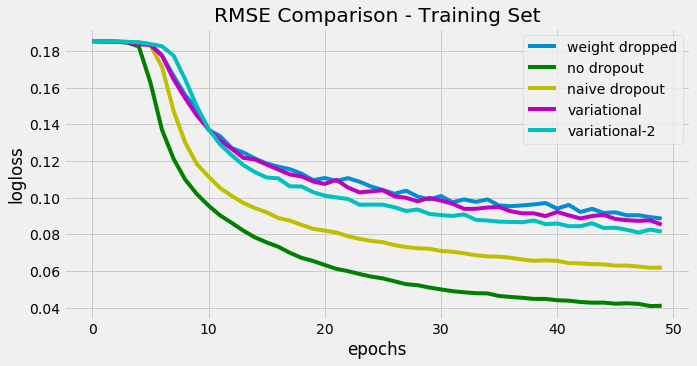

In [31]:
plt.title("RMSE Comparison - Training Set")
plt.plot(np.arange(len(epoch_losses_1)), [x[0] for x in epoch_losses_1], label="weight dropped")
plt.plot(np.arange(len(epoch_losses_2)), [x[0] for x in epoch_losses_2], "g-", label="no dropout")
plt.plot(np.arange(len(epoch_losses_3)), [x[0] for x in epoch_losses_3], "y-", label="naive dropout")
plt.plot(np.arange(len(epoch_losses_4)), [x[0] for x in epoch_losses_4], "m-", label="variational")
plt.plot(np.arange(len(epoch_losses_5)), [x[0] for x in epoch_losses_5], "c-", label="variational-2")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("logloss")

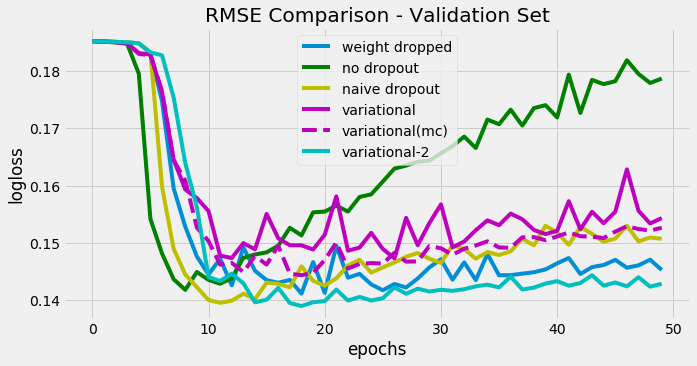

In [33]:
plt.title("RMSE Comparison - Validation Set")
plt.plot(np.arange(len(epoch_losses_1)), [x[1] for x in epoch_losses_1], label="weight dropped")
plt.plot(np.arange(len(epoch_losses_2)), [x[1] for x in epoch_losses_2], "g-", label="no dropout")
plt.plot(np.arange(len(epoch_losses_3)), [x[1] for x in epoch_losses_3], "y-", label="naive dropout")
plt.plot(np.arange(len(epoch_losses_4)), [x[1] for x in epoch_losses_4], "m-", label="variational")
plt.plot(np.arange(len(epoch_losses_4)), [x[2] for x in epoch_losses_4], "m--", label="variational(mc)")
plt.plot(np.arange(len(epoch_losses_5)), [x[1] for x in epoch_losses_5], "c-", label="variational-2")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("logloss")